In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle, clean
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import print_results,sphere_mask,fourier_filter,get_gradient_P, get_mask_weights
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, Gauss_Newton_Linear, Gauss_Newton_Linear1

In [5]:
july26_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_10.p','rb'))
july26_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_8.p','rb'))
july26_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_6_4.p','rb'))

In [6]:
july26_dict_large_rot = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_large_rot.p','rb'))

In [7]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/July_26_2016_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = clean(os.listdir(path))
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [8]:
def rep_to_angle(rep, rot_range):
    counter = rep % 6
    rotation_angle = 0.0
    translation_step = rep / 6 

    if rot_range == '0_5_to_2_5':
        if(counter != 0):
            rotation_angle = 0.5 * counter
    elif rot_range == '3_0_to_5_0':
        if(counter != 0):
            rotation_angle = 3.0 + (0.5 * (counter - 1))
    elif rot_range == '2_5_to_12_5':
        if(counter != 0):
            rotation_angle = 2.5 + (2.5 * (counter - 1))        
    elif rot_range == '15_to_25':
        if(counter != 0):
            rotation_angle = 15 + (2.5 * (counter - 1))
    else:
        print 'Invalid range of rotation'
    return rotation_angle, translation_step

In [9]:
def normalize(volume, scale):
    assert((volume >= 0).all())
    return volume * scale

In [10]:
# def RMS(dRM, dt, rad, res):
#     rad = 100
#     t = dt*res
#     return np.arccos((np.trace(dRM)-1)/2.)

def RMS(dRM, dt, rad, res):
    rad = 100
    A = dRM-np.eye(3)
    t = dt*res
    return np.sqrt(0.2*rad**2*np.trace((A.T).dot(A))+ (t.T).dot(t))
    
from conversion import rotation_matrix_fromq, rotation_matrix_from_params
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    true_RM = rotation_matrix_fromq(rot_angle[0],wx,wy,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], true_RM

def get_params(errors, Ps, res):
    params = Ps[-1]
    RM = rotation_matrix_from_params(params[3:])
    return  params[:3]*res, RM

In [11]:
ranges = ['0_5_to_2_5','3_0_to_5_0', '2_5_to_12_5','15_to_25']

In [14]:
%%time
## NORMALIZED VOLUMES
## Tricubic
# Calculate the radius for masking
res = '8mm'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
org_volume = july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)]
scale = 1./(org_volume.max()-org_volume.min())

testVol1_normed = normalize(fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)],rad), scale)
testVol2_normed = normalize(fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)],rad), scale)
s0,s1,s2 = testVol1_normed.shape

testVol1_normed_masked = sphere_mask(testVol1_normed,rad)

vol1_normed_grad = get_gradient_P(testVol1_normed, mask = True)
vol1_normed_grad = get_gradient_P(testVol2_normed, mask = True)
vol2_normed_dervs = tricubic_derivatives(testVol2_normed)

CPU times: user 51.5 s, sys: 654 ms, total: 52.1 s
Wall time: 29 s


In [12]:
%%time
## NORMALIZED VOLUMES
## Cubic B-spline
# Calculate the radius for masking
res = '8mm'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
org_volume = july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)]
scale = 1./(org_volume.max()-org_volume.min())

testVol1_normed = normalize(fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)],rad), scale)
testVol2_normed = normalize(fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)],rad), scale)
s0,s1,s2 = testVol1_normed.shape

testVol1_normed_masked = sphere_mask(testVol1_normed,rad)

vol1_normed_grad = get_gradient_P(testVol1_normed, axis_derivatives = BSpline_derivatives, mask = True)
vol1_normed_grad = get_gradient_P(testVol2_normed, axis_derivatives = BSpline_derivatives, mask = True)
vol2_normed_dervs = BSpline_coefficients(testVol2_normed)

CPU times: user 6.21 s, sys: 98.4 ms, total: 6.31 s
Wall time: 6.01 s


In [15]:
%%time
## NON-NORMALIZED VOLUMES
## Cubic B-spline
# Calculate the radius for masking
res = '8mm'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol_ref = fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(0, 0)],rad)
testVol_mov = fourier_filter(july26_dict_large_rot[res][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)],rad)
s0,s1,s2 = testVol_ref.shape

testVol_mov_masked = sphere_mask(testVol_mov,rad)

vol_ref_grad = get_gradient_P(testVol_ref, axis_derivatives = BSpline_derivatives, mask = True)
vol_mov_grad = get_gradient_P(testVol_mov, axis_derivatives = BSpline_derivatives, mask = True)
vol_ref_dervs = BSpline_coefficients(testVol_ref)

CPU times: user 5.95 s, sys: 86 ms, total: 6.04 s
Wall time: 5.77 s


Converged in 17 iterations!


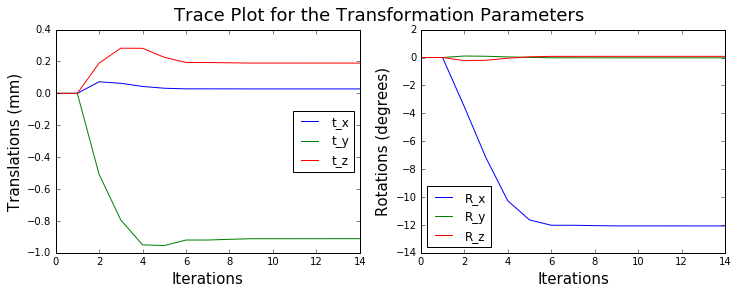

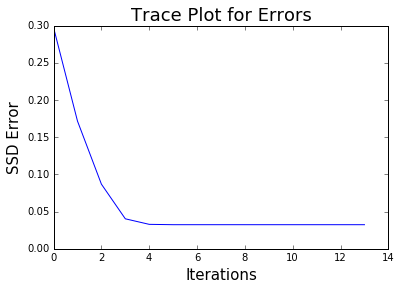

min error:  0.0323998571612
parameters at min error:  [ 0.00350364 -0.11391913  0.02374831 -0.21073973 -0.00043938  0.00144832]
translation (in mm): [ 0.02802914 -0.91135304  0.18998646]
vector of rotation: [-0.99997421 -0.00208488  0.00687239]
rotations (in degrees): 12.0748082352
theta 12.0748082352
RMS 1.04746252378


In [16]:
# GN1 with mask, non-normalized volume, Linear
res = '8'
errors, Ps = Gauss_Newton_Linear(testVol_mov_masked, vol_mov_grad, testVol_ref, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 20, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)

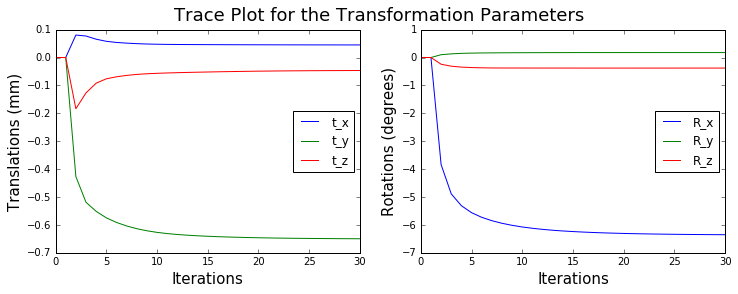

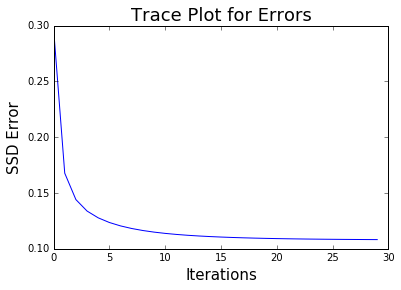

min error:  0.108242728873
parameters at min error:  [ 0.0056305  -0.08120662 -0.00582334 -0.11085787  0.0030946  -0.00661124]
translation (in mm): [ 0.04504398 -0.649653   -0.0465867 ]
vector of rotation: [-0.99783911  0.02785474 -0.05950819]
rotations (in degrees): 6.36544325711
theta 6.36544325711
RMS 6.83038978019


In [17]:
# GN1 with mask, non-normalized volume, Linear
from Gauss_Newton import Gauss_Newton_Linear1
errors, Ps = Gauss_Newton_Linear1(testVol_mov_masked, testVol_ref, vol_ref_grad, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 30, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)

Converged in 10 iterations!


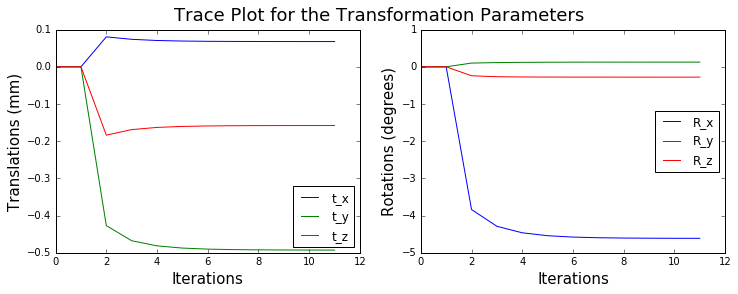

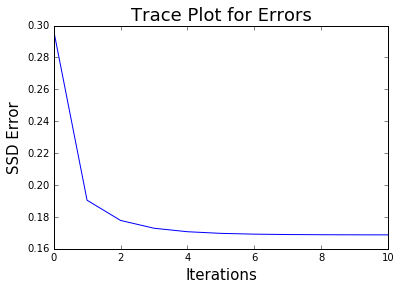

min error:  0.168742688207
parameters at min error:  [ 0.00848224 -0.06158062 -0.01972975 -0.08047591  0.0022067  -0.0048454 ]
translation (in mm): [ 0.06785788 -0.49264495 -0.15783799]
vector of rotation: [-0.99781863  0.02736079 -0.06007794]
rotations (in degrees): 4.62101032152
theta 4.62101032152
RMS 8.72350145528


In [18]:
# GN1 with mask, non-normalized volume
errors, Ps = Gauss_Newton1(testVol_mov_masked, testVol_ref, vol_ref_dervs, vol_ref_grad, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 30, decrease_factor = 0.25, interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)

Converged in 13 iterations!


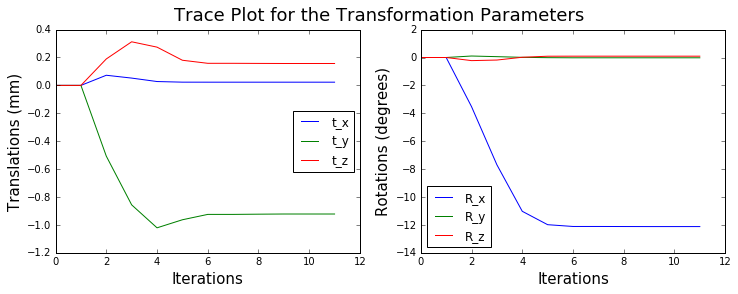

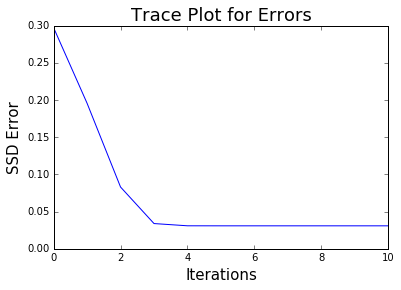

min error:  0.0308824030912
parameters at min error:  [ 0.00288414 -0.11523987  0.0196294  -0.21153276 -0.00036268  0.00164296]
translation (in mm): [ 0.02307312 -0.92191895  0.15703517]
vector of rotation: [-0.99996837 -0.0017145   0.00776667]
rotations (in degrees): 12.1203177075
theta 12.1203177075
RMS 1.03073401161


In [19]:
# GN with mask, non-normalized volume
errors, Ps = Gauss_Newton(testVol_mov_masked, vol_mov_grad, testVol_ref, vol_ref_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 30, decrease_factor = 0.25, interp = Bspline_interp)
print_results(errors, Ps, float('.'.join(res.split('_'))))

theta = np.linalg.norm(Ps[-1][3:])
print 'theta', theta*180/np.pi

rM = rotation_matrix_from_params(Ps[-1][3:])
real_rM = rotation_matrix_fromq(-12.5,1,0,0)

print 'RMS', RMS(rM.dot(real_rM.T), Ps[-1][:3], 16, 8)

In [20]:
## count pairs
count = 0
for ax in axes_dict.keys():
    cost_dict = {}
    for rang in ranges:
        for rep in xrange(1,36):
            count += 1
print count

840


In [ ]:
errors, Ps = Gauss_Newton_Linear(testVol_mov_masked, vol_mov_grad, testVol_ref, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)

errors, Ps = Gauss_Newton_Linear1(testVol_mov_masked, testVol_ref, vol_ref_grad, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)

errors, Ps = Gauss_Newton1(testVol_mov_masked, testVol_ref, vol_ref_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)

errors, Ps = Gauss_Newton(testVol_mov_masked, vol_mov_grad, testVol_ref, vol_ref_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)

## Run Gauss Newton with BSplines on all data

In [21]:
import multiprocessing
def run_GN_Bsplines(rot_ax):
    print rot_ax,
    cost_dict = {}
    cost_dict[1] = {}
    cost_dict[2] = {}
    for rang in ranges:
        print rang,
        ref = rep_to_angle(0,rang)
        vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
        vol_ref_dervs = BSpline_coefficients(vol_ref)
        vol_ref_grad = get_gradient_P(vol_ref, mask = True, axis_derivatives=BSpline_derivatives)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            print rep,
            print rot_angle,
            vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
            vol_m_masked = mask_weights*vol_m
            vol_m_grad = get_gradient_P(vol_m, mask = True, axis_derivatives=BSpline_derivatives)
            cost_dict[2][rot_angle] = Gauss_Newton(vol_m_masked, vol_m_grad, vol_ref, vol_ref_dervs, mask=True, 
                                                  divide_factor = 1., alpha = 1., max_iter = 35, 
                                                  plot = False, decrease_factor = 0.25,interp = Bspline_interp)
            cost_dict[1][rot_angle] = Gauss_Newton1(vol_m_masked, vol_ref, vol_ref_dervs, vol_ref_grad, mask=True, 
                                                   divide_factor = 1., alpha = 1., max_iter = 35,
                                                   plot = False, decrease_factor = 0.25,interp = Bspline_interp)
    return cost_dict

In [22]:
def run_GN_tricubic(rot_ax):
    print rot_ax,
    cost_dict = {}
    cost_dict[1] = {}
    cost_dict[2] = {}
    for rang in ranges:
        print rang,
        ref = rep_to_angle(0,rang)
        print ref
        vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
        vol_ref_dervs = tricubic_derivatives(vol_ref)
        vol_ref_grad = get_gradient_P(vol_ref, mask = True)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            print rot_angle,
            vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
            vol_m_masked = mask_weights*vol_m
            vol_m_grad = get_gradient_P(vol_m, mask=True)
            cost_dict[2][rot_angle] = Gauss_Newton(vol_m_masked, vol_m_grad, vol_ref, vol_ref_dervs, mask=True, 
                                                  divide_factor = 1., alpha = 1., max_iter = 35, 
                                                  plot = False, decrease_factor = 0.25)
            cost_dict[1][rot_angle] = Gauss_Newton1(vol_m_masked, vol_ref, vol_ref_dervs, vol_ref_grad, mask=True, 
                                                   divide_factor = 1., alpha = 1., max_iter = 35,
                                                   plot = False, decrease_factor = 0.25)
    return cost_dict

In [23]:
%%time
## Large Rotations
ranges = ['2_5_to_12_5','15_to_25']
res = '10mm'
rad = res_to_rad(res)
dict_ = july26_dict_large_rot[res]
mask_weights = get_mask_weights((26,26,26),rad)

cost_dict = run_GN_Bsplines('x')
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_large_rot_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

x 2_5_to_12_5 1 (2.5, 0) Converged in 9 iterations!
Converged in 8 iterations!
2 (5.0, 0) Converged in 7 iterations!
Converged in 7 iterations!
3 (7.5, 0) Converged in 4 iterations!
Converged in 16 iterations!
4 (10.0, 0) Converged in 5 iterations!
Converged in 24 iterations!
5 (12.5, 0) Converged in 6 iterations!
Converged in 15 iterations!
6 (0.0, 1) Converged in 4 iterations!
Converged in 2 iterations!
7 (2.5, 1) Converged in 8 iterations!
Converged in 8 iterations!
8 (5.0, 1) Converged in 4 iterations!
Converged in 8 iterations!
9 (7.5, 1) Converged in 5 iterations!
Converged in 18 iterations!
10 (10.0, 1) Converged in 5 iterations!
Converged in 24 iterations!
11 (12.5, 1) Converged in 9 iterations!
Converged in 14 iterations!
12 (0.0, 2) Converged in 7 iterations!
Converged in 2 iterations!
13 (2.5, 2) Converged in 10 iterations!
Converged in 10 iterations!
14 (5.0, 2) Converged in 4 iterations!
Converged in 10 iterations!
15 (7.5, 2) Converged in 5 iterations!
Converged in 22 ite

In [24]:
%%time
## Large Rotations
ranges = ['2_5_to_12_5','15_to_25']
res = '8mm'
rad = res_to_rad(res)
dict_ = july26_dict_large_rot[res]
mask_weights = get_mask_weights((32,32,32),rad)

cost_dict = run_GN_Bsplines('x')
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_large_rot_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

x 2_5_to_12_5 1 (2.5, 0) Converged in 3 iterations!
Converged in 4 iterations!
2 (5.0, 0) Converged in 5 iterations!
Converged in 10 iterations!
3 (7.5, 0) Converged in 8 iterations!
4 (10.0, 0) Converged in 12 iterations!
Converged in 21 iterations!
5 (12.5, 0) Converged in 13 iterations!
Converged in 10 iterations!
6 (0.0, 1) Converged in 2 iterations!
Converged in 2 iterations!
7 (2.5, 1) Converged in 3 iterations!
Converged in 7 iterations!
8 (5.0, 1) Converged in 5 iterations!
Converged in 12 iterations!
9 (7.5, 1) Converged in 10 iterations!
10 (10.0, 1) Converged in 9 iterations!
Converged in 17 iterations!
11 (12.5, 1) Converged in 15 iterations!
Converged in 9 iterations!
12 (0.0, 2) Converged in 3 iterations!
Converged in 3 iterations!
13 (2.5, 2) Converged in 4 iterations!
Converged in 6 iterations!
14 (5.0, 2) Converged in 5 iterations!
Converged in 14 iterations!
15 (7.5, 2) Converged in 6 iterations!
16 (10.0, 2) Converged in 11 iterations!
Converged in 16 iterations!
17 

In [ ]:
%%time
## Large Rotations
ranges = ['2_5_to_12_5','15_to_25']
res = '6_4mm'
rad = res_to_rad(res)
dict_ = july26_dict_large_rot[res]
mask_weights = get_mask_weights((40,40,40),rad)

cost_dict = run_GN_Bsplines('x')
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_large_rot_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

x 2_5_to_12_5 1 (2.5, 0) Converged in 3 iterations!
Converged in 5 iterations!
2 (5.0, 0) Converged in 5 iterations!
Converged in 15 iterations!
3 (7.5, 0) Converged in 6 iterations!
Converged in 17 iterations!
4 (10.0, 0) Converged in 10 iterations!
Converged in 8 iterations!
5 (12.5, 0) Converged in 10 iterations!
Converged in 6 iterations!
6 (0.0, 1) Converged in 4 iterations!
Converged in 2 iterations!
7 (2.5, 1) Converged in 3 iterations!
Converged in 6 iterations!
8 (5.0, 1) Converged in 5 iterations!
Converged in 17 iterations!
9 (7.5, 1) Converged in 6 iterations!
Converged in 16 iterations!
10 (10.0, 1) Converged in 12 iterations!
Converged in 8 iterations!
11 (12.5, 1) Converged in 11 iterations!
Converged in 6 iterations!
12 (0.0, 2) Converged in 3 iterations!
Converged in 4 iterations!
13 (2.5, 2) Converged in 5 iterations!
Converged in 7 iterations!
14 (5.0, 2) Converged in 5 iterations!
Converged in 22 iterations!
15 (7.5, 2) Converged in 6 iterations!
Converged in 15 ite

In [ ]:
%%time
## Large Rotations Tricubic
resolutions = ['10mm','8mm','6_4mm']
ranges = ['2_5_to_12_5','15_to_25']
for res in resolutions:
    rad = res_to_rad(res)
    dict_ = july26_dict_large_rot[res]
    mask_weights = get_mask_weights((rad*2,rad*2,rad*2),rad)

    cost_dict = run_GN_tricubic('x')
    filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_large_rot_tricubic_GN2_%s.p' % (res)
    pickle.dump(cost_dict,open(filename,'wb'))

x 2_5_to_12_5 (0.0, 0)
(2.5, 0) Converged in 8 iterations!
Converged in 8 iterations!
(5.0, 0) Converged in 10 iterations!
Converged in 5 iterations!
(7.5, 0) Converged in 7 iterations!
Converged in 11 iterations!
(10.0, 0) Converged in 9 iterations!
Converged in 34 iterations!
(12.5, 0) Converged in 11 iterations!
Converged in 21 iterations!
(0.0, 1) Converged in 7 iterations!
Converged in 8 iterations!
(2.5, 1) Converged in 10 iterations!
Converged in 10 iterations!
(5.0, 1) Converged in 10 iterations!
Converged in 5 iterations!
(7.5, 1) Converged in 8 iterations!
Converged in 13 iterations!
(10.0, 1) Converged in 9 iterations!
(12.5, 1) Converged in 11 iterations!
Converged in 19 iterations!
(0.0, 2) Converged in 13 iterations!
Converged in 10 iterations!
(2.5, 2) Converged in 10 iterations!
Converged in 10 iterations!
(5.0, 2) Converged in 10 iterations!
Converged in 6 iterations!
(7.5, 2) Converged in 10 iterations!
Converged in 15 iterations!
(10.0, 2) Converged in 13 iterations!

In [27]:
ranges = ['0_5_to_2_5','3_0_to_5_0']

In [28]:
%%time
res = '10'
rad = res_to_rad(res)
dict_ = july26_dict_10
mask_weights = get_mask_weights((26,26,26),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Bsplines, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
CPU times: user 801 ms, sys: 166 ms, total: 967 ms
Wall time: 8min 20s
xz 0_5_to_2_5 y 0_5_to_2_5 yz 0_5_to_2_5 xy 0_5_to_2_5 z 0_5_to_2_5 x 0_5_to_2_5 1 (0.5, 0) 1 (0.5, 0) 1 (0.5, 0) 1 (0.5, 0) 1 (0.5, 0) 1 (0.5, 0) Converged in 2 iterations!
Converged in 2 iterations!
Converged in 2 iterations!
Converged in 2 iterations!
Converged in 2 iterations!
Converged in 2 iterations!
Converged in 5 iterations!Converged in 5 iterations!Converged in 2 iterations!Converged in 5 iterations!Converged in 2 iterations!Converged in 5 iterations!





2 (1.0, 0) 2 (1.0, 0) 2 (1.0, 0) 2 (1.0, 0) 2 (1.0, 0) 2 (1.0, 0) Converged in 3 iterations!
Converged in 2 iterations!
Converged in 2 iterations!
Converged in 4 iterations!
Converged in 2 iterations!
Converged in 4 iterations!
Converged in 2 iterations!Converged in 7 iterations!Converged in 2 iterations!Converged in 7 iterations!Converged in 2 iterations!Converged in 7 iterations!





3 (1.5, 0) 3 (1.5, 0) 3 (1.5, 0) 3

In [29]:
%%time
res = '8'
rad = res_to_rad(res)
dict_ = july26_dict_8
mask_weights = get_mask_weights((32,32,32),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Bsplines, keys)

filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) Converged in 4 iterations!
Converged in 5 iterations!
Converged in 12 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged in 7 iterations!
Converged in 10 iterations!Converged in 8 iterations!Converged in 6 iterations!Converged in 12 iterations!Converged in 4 iterations!Converged in 10 iterations!





23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) Converged in 4 iterations!
Converged in 5 iterations!
Converged in 13 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged in 7 iterations!
Converged in 14 iterations!Converged in 10 iterations!Converged in 7 iterations!Converged in 8 iterations!Converged in 4 iterations!Converged in 10 iterations!





24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) Converged in 10 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged

In [30]:
%%time
res = '6_4'
rad = res_to_rad(res)
dict_ = july26_dict_6_4
mask_weights = get_mask_weights((40,40,40),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Bsplines, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) Converged in 4 iterations!
Converged in 9 iterations!
Converged in 5 iterations!
Converged in 7 iterations!
Converged in 7 iterations!
Converged in 3 iterations!
Converged in 11 iterations!Converged in 11 iterations!Converged in 9 iterations!Converged in 17 iterations!Converged in 6 iterations!Converged in 5 iterations!





23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) Converged in 4 iterations!
Converged in 9 iterations!
Converged in 5 iterations!
Converged in 7 iterations!
Converged in 7 iterations!
Converged in 3 iterations!
Converged in 9 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 11 iterations!Converged in 7 iterations!Converged in 5 iterations!





24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) Converged in 12 iterations!
Converged in 12 iterations!
Converged in 5 iterations!
Converged in 11 iterations!
Converged

In [31]:
%%time
res = '10'
rad = res_to_rad(res)
dict_ = july26_dict_10
mask_weights = get_mask_weights((26,26,26),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_tricubic, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_tricubic_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) 22 (2.0, 3) Converged in 7 iterations!
Converged in 4 iterations!
Converged in 9 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged in 5 iterations!
Converged in 7 iterations!Converged in 11 iterations!Converged in 16 iterations!Converged in 9 iterations!Converged in 9 iterations!Converged in 6 iterations!





23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) 23 (2.5, 3) Converged in 9 iterations!
Converged in 4 iterations!
Converged in 9 iterations!
Converged in 4 iterations!
Converged in 4 iterations!
Converged in 5 iterations!
Converged in 8 iterations!Converged in 12 iterations!Converged in 20 iterations!Converged in 9 iterations!Converged in 10 iterations!Converged in 7 iterations!





24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) 24 (0.0, 4) Converged in 5 iterations!
Converged in 4 iterations!
Converged in 7 iterations!
Converged in 4 iterations!
Converged in 

In [32]:
%%time
res = '8'
rad = res_to_rad(res)
dict_ = july26_dict_8
mask_weights = get_mask_weights((32,32,32),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_tricubic, keys)

filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_tricubic_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
(2.0, 3) (2.0, 3) (2.0, 3) (2.0, 3) Converged in 8 iterations!
Converged in 15 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 15 iterations!
Converged in 10 iterations!
Converged in 8 iterations!Converged in 10 iterations!Converged in 5 iterations!Converged in 10 iterations!Converged in 10 iterations!Converged in 12 iterations!





(2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) Converged in 8 iterations!
Converged in 10 iterations!
Converged in 10 iterations!
Converged in 10 iterations!
Converged in 14 iterations!
Converged in 15 iterations!
Converged in 8 iterations!Converged in 10 iterations!Converged in 5 iterations!Converged in 10 iterations!Converged in 8 iterations!Converged in 10 iterations!





(0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) Converged in 12 iterations!
Converged in 12 iterations!
Converged in 13 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 12 i

In [33]:
%%time
res = '6_4'
rad = res_to_rad(res)
dict_ = july26_dict_6_4
mask_weights = get_mask_weights((40,40,40),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_tricubic, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_tricubic_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
(2.0, 3) (2.0, 3) (2.0, 3) (2.0, 3) Converged in 10 iterations!
Converged in 10 iterations!
Converged in 16 iterations!
Converged in 15 iterations!
Converged in 15 iterations!
Converged in 11 iterations!
Converged in 10 iterations!Converged in 13 iterations!Converged in 10 iterations!Converged in 10 iterations!Converged in 12 iterations!Converged in 5 iterations!





(2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) Converged in 10 iterations!
Converged in 8 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 14 iterations!
Converged in 11 iterations!
Converged in 10 iterations!Converged in 13 iterations!Converged in 12 iterations!Converged in 5 iterations!Converged in 12 iterations!Converged in 5 iterations!





(0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) Converged in 14 iterations!
Converged in 11 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 1

In [ ]:
cost_dict_bsplines_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN_6_4.p','rb'))
cost_dict_bsplines_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN_8.p','rb'))
cost_dict_bsplines_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_BSpline_GN_10.p','rb'))

true_params = []
RMS_ls_bspline_6_4 = [] 
RMS_ls_bspline_8 = []
RMS_ls_bspline_10 = []
for ix, rot_ax in enumerate(axes_dict.keys()):
    for rang in ranges:
        ref = rep_to_angle(0,rang)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            true_params.append(rot_angle)
            true_t, true_RM = get_true_params(rot_angle,rot_ax)
            
            res = '6_4'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_bsplines_6_4[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM)
            RMS_ls_bspline_6_4.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))            
            
            res = '8'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_bsplines_8[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM)
            RMS_ls_bspline_8.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))
            
            res = '10'
            rad = res_to_rad(res)           
            errors, Ps = cost_dict_bsplines_10[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM)
            RMS_ls_bspline_10.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))

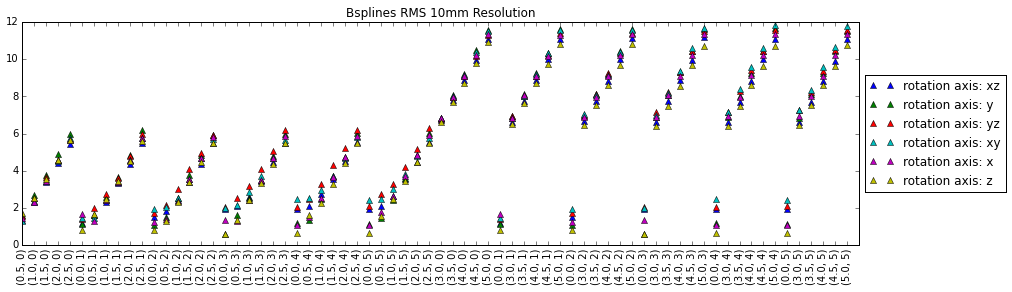

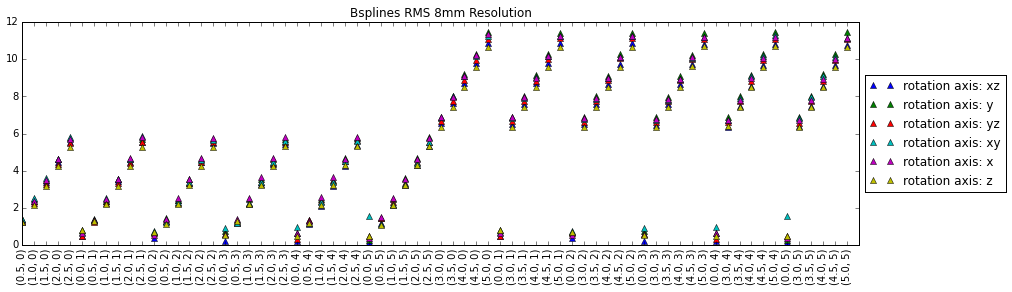

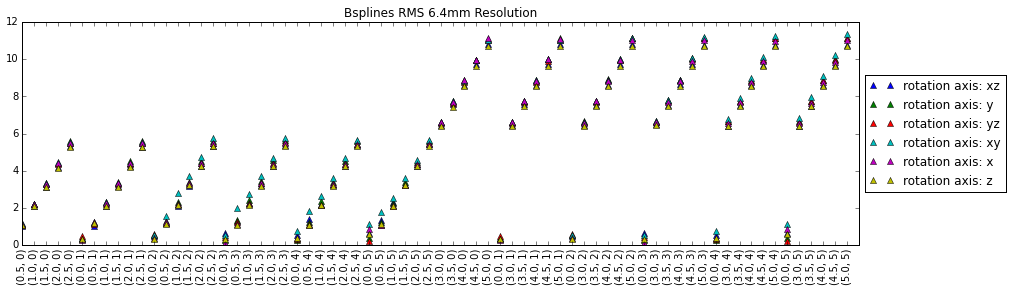

In [250]:
x = np.arange(0,70,1)
labels = true_params[:70]

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_bspline_10[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Bsplines RMS 10mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_bspline_8[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Bsplines RMS 8mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_bspline_6_4[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Bsplines RMS 6.4mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Run Gauss Newton with Trilinear on all data

In [11]:
dict_ = july26_dict_10
def run_GN_Linear(rot_ax):
    print rot_ax,
    cost_dict = {}
    cost_dict[1] = {}
    cost_dict[2] = {}
    for rang in ranges:
        print rang,
        ref = rep_to_angle(0,rang)
        vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
        vol_ref_grad = get_gradient_P(vol_ref, mask=True)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            print rot_angle,
            vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
            vol_m_masked = mask_weights*vol_m
            vol_m_grad = get_gradient_P(vol_m, mask=True)
            cost_dict[2][rot_angle] = Gauss_Newton_Linear(vol_m_masked, vol_m_grad, vol_ref, mask=True, 
                                                          divide_factor = 1., alpha = 1., max_iter = 30, 
                                                          plot = False, decrease_factor = 0.25)
            cost_dict[1][rot_angle] = Gauss_Newton_Linear1(vol_m_masked, vol_ref, vol_ref_grad, mask=True, 
                                                           divide_factor = 1., alpha = 1., max_iter = 30, 
                                                           plot = False, decrease_factor = 0.25)


    return cost_dict

In [35]:
%%time
## Large Rotations Trilinear
resolutions = ['10mm','8mm','6_4mm']
ranges = ['2_5_to_12_5','15_to_25']
for res in resolutions:
    rad = res_to_rad(res)
    dict_ = july26_dict_large_rot[res]
    mask_weights = get_mask_weights((rad*2,rad*2,rad*2),rad)

    cost_dict = run_GN_Linear('x')
    filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_large_rot_Linear_GN2_%s.p' % (res)
    pickle.dump(cost_dict,open(filename,'wb'))

x 2_5_to_12_5 (3.5, 1) (3.5, 1) Converged in 10 iterations!
Converged in 14 iterations!
Converged in 10 iterations!Converged in 11 iterations!
Converged in 12 iterations!
Converged in 8 iterations!
Converged in 6 iterations!Converged in 4 iterations!
Converged in 10 iterations!Converged in 6 iterations!Converged in 4 iterations!

(4.0, 1) 


(4.0, 1) (4.0, 1) Converged in 13 iterations!
(4.0, 1) (4.0, 1) (4.0, 1) Converged in 8 iterations!
Converged in 14 iterations!
Converged in 10 iterations!Converged in 11 iterations!
Converged in 12 iterations!
Converged in 9 iterations!
Converged in 7 iterations!Converged in 4 iterations!
Converged in 12 iterations!Converged in 8 iterations!Converged in 5 iterations!

(4.5, 1) 


(4.5, 1) (4.5, 1) Converged in 12 iterations!
(4.5, 1) (4.5, 1) (4.5, 1) Converged in 10 iterations!
Converged in 15 iterations!
Converged in 10 iterations!Converged in 11 iterations!
Converged in 9 iterations!
Converged in 9 iterations!
Converged in 9 iterations!Converge

In [13]:
ranges = ['0_5_to_2_5','3_0_to_5_0']

In [14]:
%%time
res = '10'
rad = res_to_rad(res)
dict_ = july26_dict_10
mask_weights = get_mask_weights((26,26,26),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Linear, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
CPU times: user 771 ms, sys: 102 ms, total: 873 ms
Wall time: 5min 41s
y 0_5_to_2_5 xz 0_5_to_2_5 yz 0_5_to_2_5 xy 0_5_to_2_5 x 0_5_to_2_5 z 0_5_to_2_5 (0.5, 0) (0.5, 0) (0.5, 0) (0.5, 0) (0.5, 0) (0.5, 0) Converged in 6 iterations!
Converged in 15 iterations!
Converged in 14 iterations!
Converged in 14 iterations!
Converged in 6 iterations!
Converged in 3 iterations!
Converged in 6 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 12 iterations!Converged in 3 iterations!Converged in 9 iterations!





(1.0, 0) (1.0, 0) (1.0, 0) (1.0, 0) (1.0, 0) (1.0, 0) Converged in 8 iterations!
Converged in 3 iterations!
Converged in 3 iterations!
Converged in 6 iterations!
Converged in 8 iterations!
Converged in 6 iterations!
Converged in 11 iterations!Converged in 11 iterations!Converged in 15 iterations!Converged in 11 iterations!Converged in 9 iterations!Converged in 9 iterations!





(1.5, 0) (1.5, 0) (1.5, 0) (1.5, 0) (1.5, 0) (1.

In [15]:
%%time
res = '8'
rad = res_to_rad(res)
dict_ = july26_dict_8
mask_weights = get_mask_weights((32,32,32),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Linear, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
(2.0, 3) (2.0, 3) (2.0, 3) (2.0, 3) Converged in 10 iterations!
Converged in 10 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!





(2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) Converged in 10 iterations!
Converged in 10 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!Converged in 13 iterations!





(0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) Converged in 12 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged 

In [16]:
%%time
res = '6_4'
rad = res_to_rad(res)
dict_ = july26_dict_6_4
mask_weights = get_mask_weights((40,40,40),rad)

keys =  axes_dict.keys()
print keys
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
cost_dict = pool.map(run_GN_Linear, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN2_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

['xz', 'y', 'yz', 'xy', 'x', 'z']
(2.0, 3) (2.0, 3) (2.0, 3) (2.0, 3) Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 13 iterations!Converged in 15 iterations!Converged in 13 iterations!Converged in 15 iterations!Converged in 13 iterations!Converged in 13 iterations!





(2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) (2.5, 3) Converged in 10 iterations!
Converged in 7 iterations!
Converged in 12 iterations!
Converged in 10 iterations!
Converged in 12 iterations!
Converged in 12 iterations!
Converged in 13 iterations!Converged in 15 iterations!Converged in 13 iterations!Converged in 15 iterations!Converged in 13 iterations!Converged in 13 iterations!





(0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) (0.0, 4) Converged in 10 iterations!
Converged in 6 iterations!
Converged in 14 iterations!
Converged in 5 iterations!
Converged in 10 iterations!
Converged in 

In [251]:
cost_dict_linear_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN_6_4.p','rb'))
cost_dict_linear_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN_8.p','rb'))
cost_dict_linear_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_Linear_GN_10.p','rb'))

true_params = []
RMS_ls_linear_6_4 = [] 
RMS_ls_linear_8 = []
RMS_ls_linear_10 = []
for ix, rot_ax in enumerate(axes_dict.keys()):
    for rang in ranges:
        ref = rep_to_angle(0,rang)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            true_params.append(rot_angle)
            true_t, true_RM = get_true_params(rot_angle,rot_ax)
            
            res = '6_4'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_linear_6_4[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_linear_6_4.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))            
            
            res = '8'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_linear_8[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_linear_8.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))
            
            res = '10'
            rad = res_to_rad(res)           
            errors, Ps = cost_dict_linear_10[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_linear_10.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))

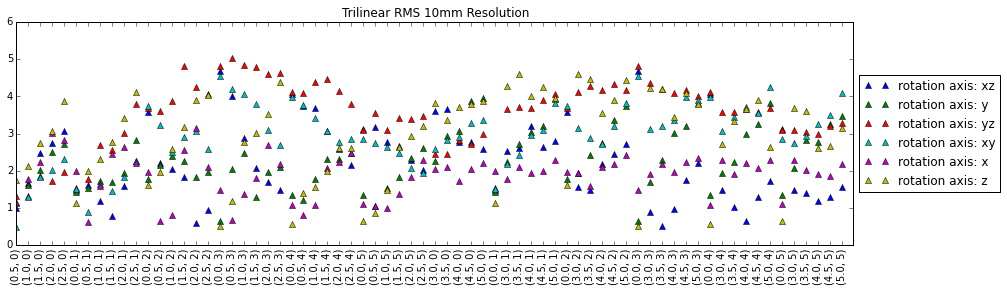

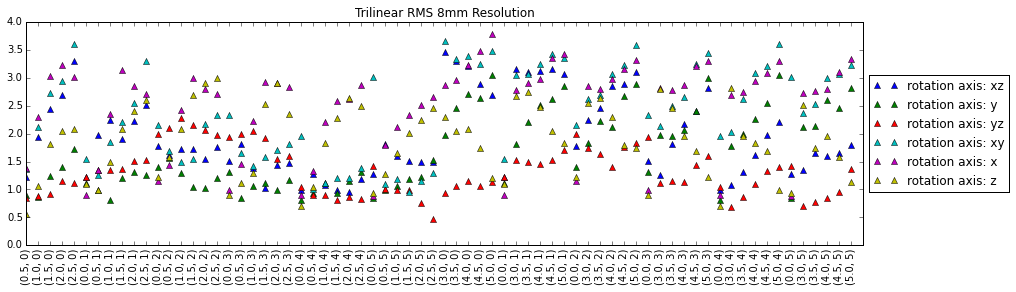

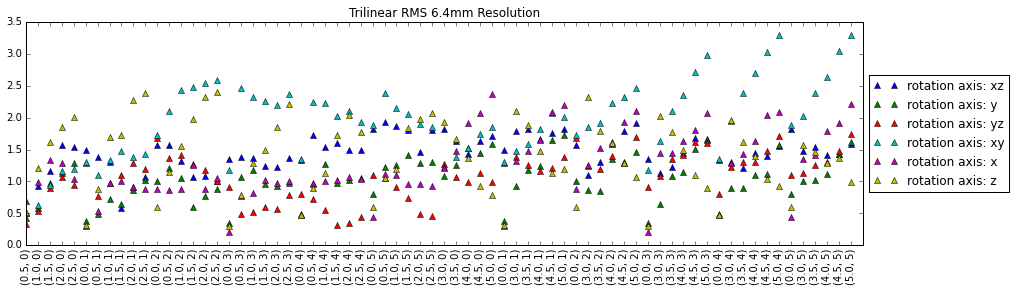

In [252]:
x = np.arange(0,70,1)
labels = true_params[:70]

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_linear_10[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Trilinear RMS 10mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_linear_8[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Trilinear RMS 8mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_linear_6_4[i*70:(i+1)*70], '^' ,label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Trilinear RMS 6.4mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Run Gauss Newton with Tricubic on all data

In [101]:
dict_ = oct13_dict_8
def run_GN_cubic(rot_ax):
    cost_dict = {}
    for rang in ranges:
        ref = rep_to_angle(0,rang)
        vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
        vol_ref_masked = sphere_mask(vol_ref,rad)
        vol_ref_dervs = get_gradient_P(vol_ref)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
            vol_m_dervs = tricubic_derivatives(vol_m)
            cost_dict[rot_angle] = Gauss_Newton(vol_ref_masked, vol_ref_dervs, vol_m, vol_m_dervs, mask=True, 
                                                 divide_factor = 1., alpha = 1., max_iter = 20, 
                                                 plot = False, decrease_factor = 0.25)
    return cost_dict

In [ ]:
res = '8'
rad = res_to_rad(res)

keys =  axes_dict.keys()
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(run_GN_cubic, keys)
filename = '/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Cubic_GN_%s.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

In [241]:
cost_dict_cubic_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_GN_6_4.p','rb'))
cost_dict_cubic_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_Cubic_GN_8.p','rb'))
cost_dict_cubic_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_GN_10.p','rb'))

true_params = []
RMS_ls_cubic_6_4 = [] 
RMS_ls_cubic_8 = []
RMS_ls_cubic_10 = []
for ix, rot_ax in enumerate(axes_dict.keys()):
    for rang in ranges:
        ref = rep_to_angle(0,rang)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            true_params.append(rot_angle)
            true_t, true_RM = get_true_params(rot_angle,rot_ax)
            
            res = '6_4'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_cubic_6_4[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_cubic_6_4.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))            
            
            res = '8'
            rad = res_to_rad(res)
            errors, Ps = cost_dict_cubic_8[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_cubic_8.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))
            
            res = '10'
            rad = res_to_rad(res)           
            errors, Ps = cost_dict_cubic_10[ix][rot_angle]
            t , RM = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = RM.dot(true_RM.T)
            RMS_ls_cubic_10.append(RMS(dR, dt,rad,float('.'.join(res.split('_')))))

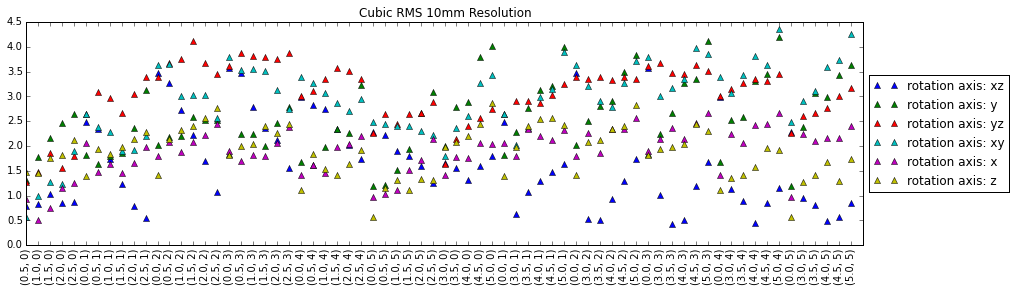

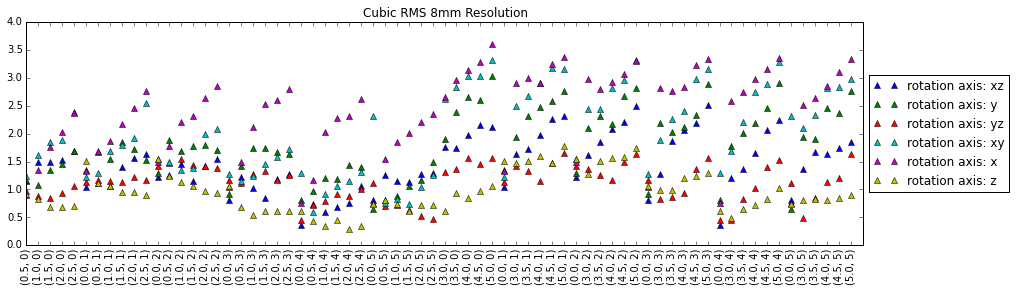

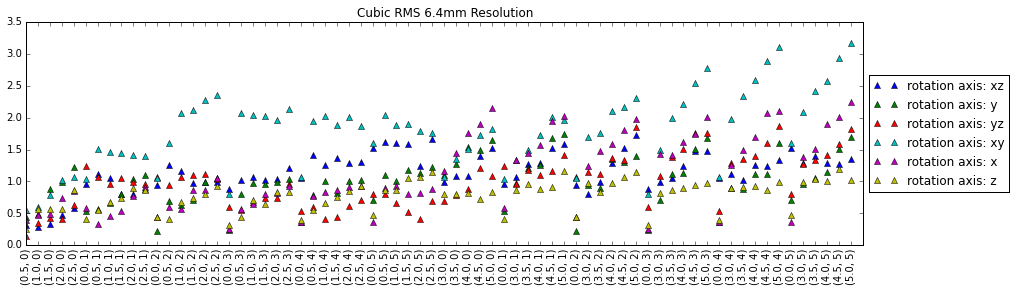

In [247]:
x = np.arange(0,70,1)
labels = true_params[:70]

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_cubic_10[i*70:(i+1)*70], '^', label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Cubic RMS 10mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_cubic_8[i*70:(i+1)*70], '^', label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Cubic RMS 8mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=[15,4])
for i in xrange(6):
    plt.plot(RMS_ls_cubic_6_4[i*70:(i+1)*70], '^', label = 'rotation axis: '+ axes_dict.keys()[i])
plt.title('Cubic RMS 6.4mm Resolution')
plt.xticks(x, labels, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

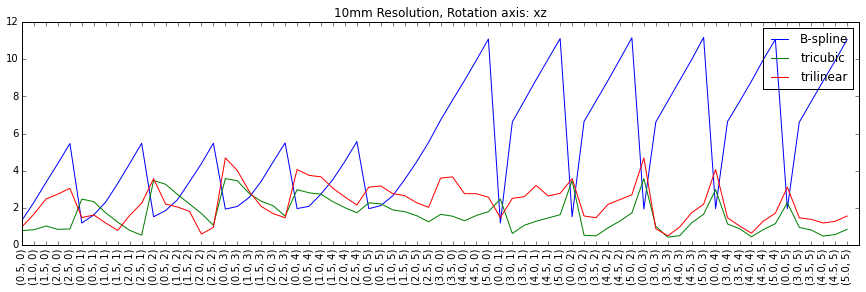

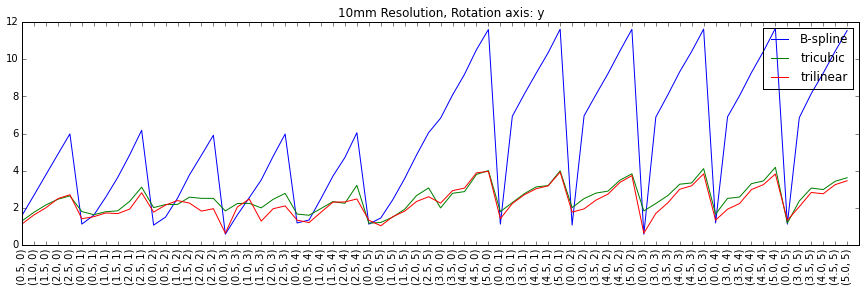

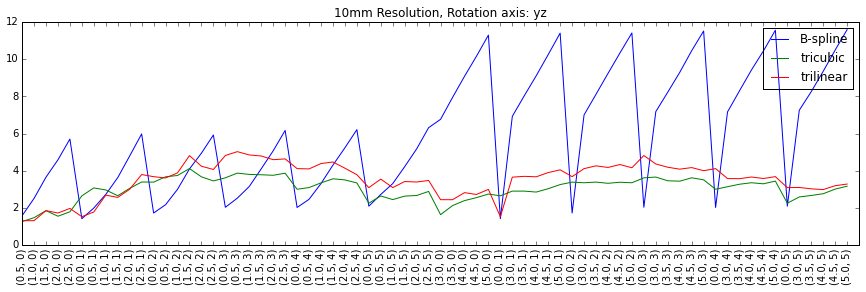

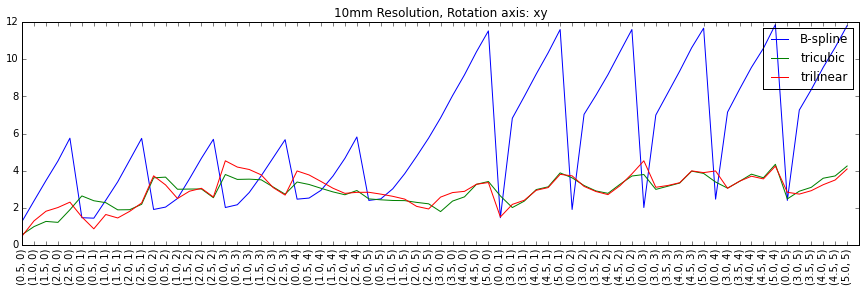

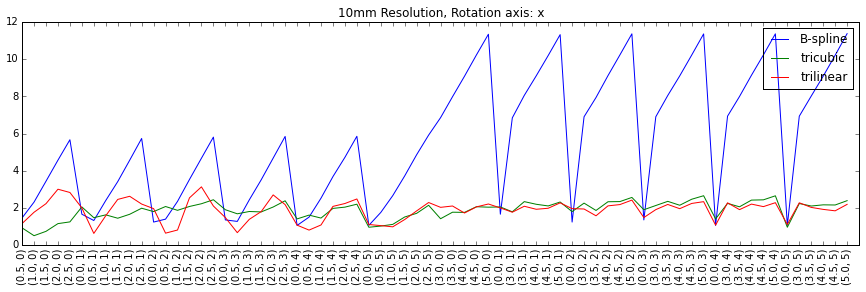

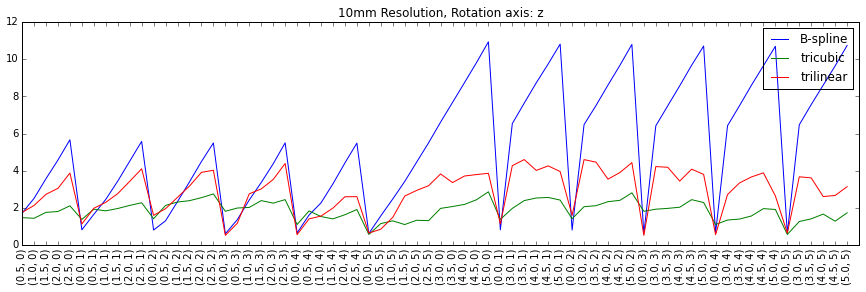

In [227]:
x = np.arange(0,70,1)
labels = true_params[:70]
for i in xrange(6):
    plt.figure(figsize=[15,4])
    plt.plot(RMS_ls_bspline_10[i*70:(i+1)*70], label = 'B-spline')
    plt.plot(RMS_ls_cubic_10[i*70:(i+1)*70], label = 'tricubic')
    plt.plot(RMS_ls_linear_10[i*70:(i+1)*70], label = 'trilinear')
    plt.title('10mm Resolution, Rotation axis: '+ axes_dict.keys()[i])
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

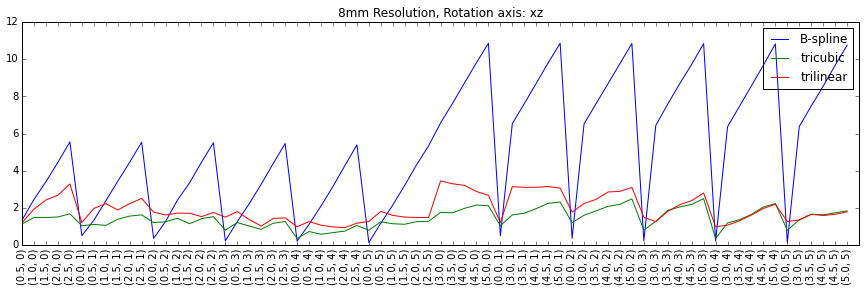

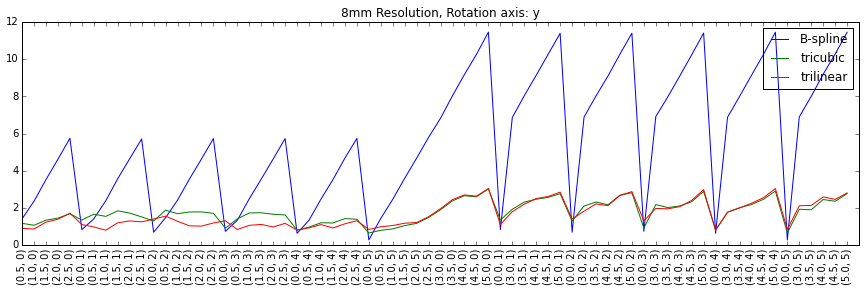

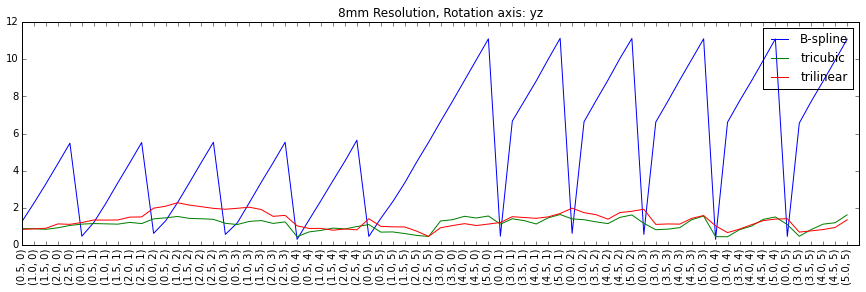

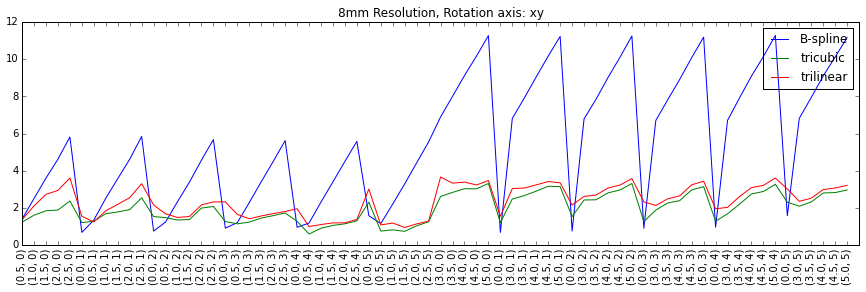

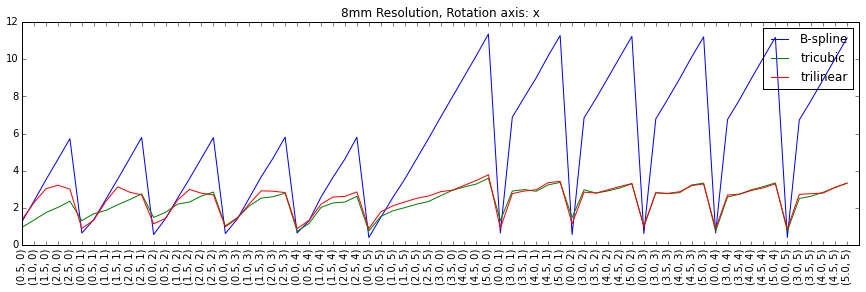

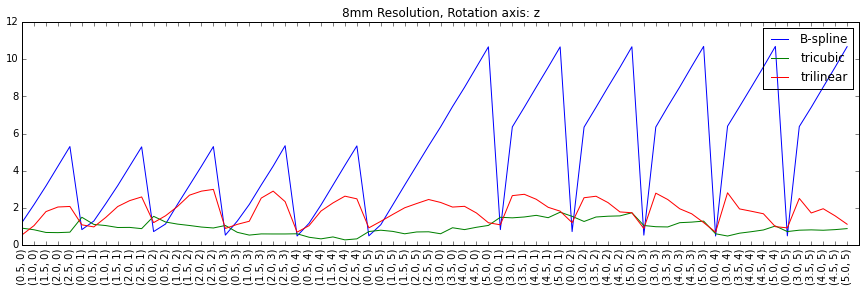

In [228]:
x = np.arange(0,70,1)
labels = true_params[:70]
for i in xrange(6):
    plt.figure(figsize=[15,4])
    plt.plot(RMS_ls_bspline_8[i*70:(i+1)*70], label = 'B-spline')
    plt.plot(RMS_ls_cubic_8[i*70:(i+1)*70], label = 'tricubic')
    plt.plot(RMS_ls_linear_8[i*70:(i+1)*70], label = 'trilinear')
    plt.title('8mm Resolution, Rotation axis: '+ axes_dict.keys()[i])
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()

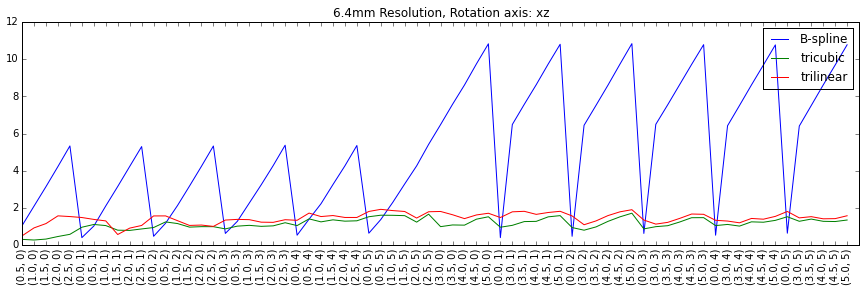

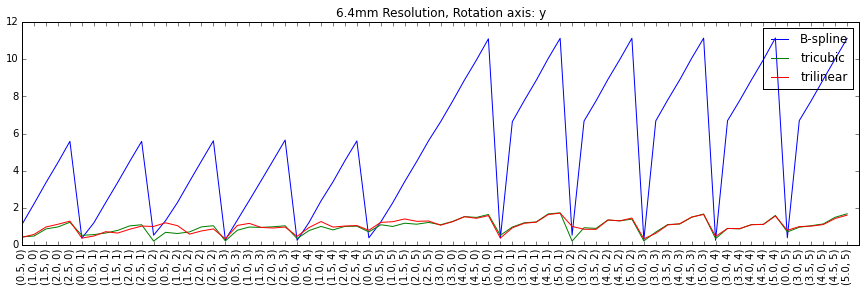

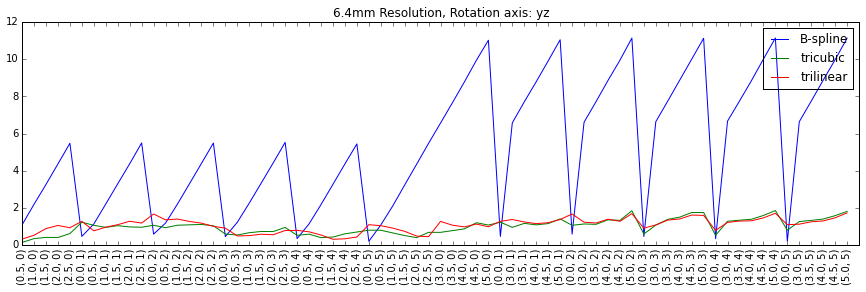

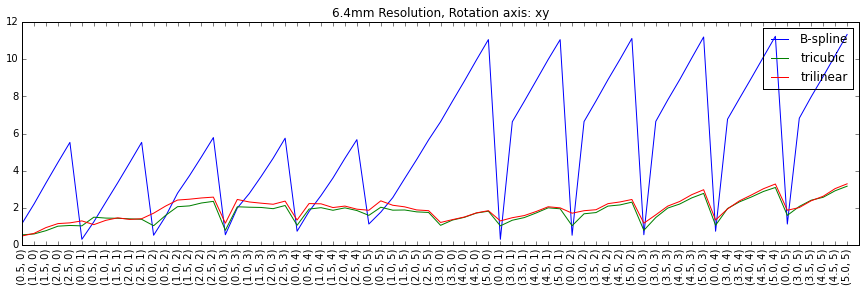

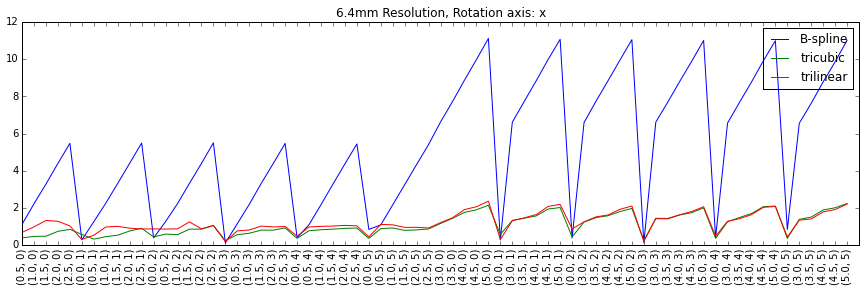

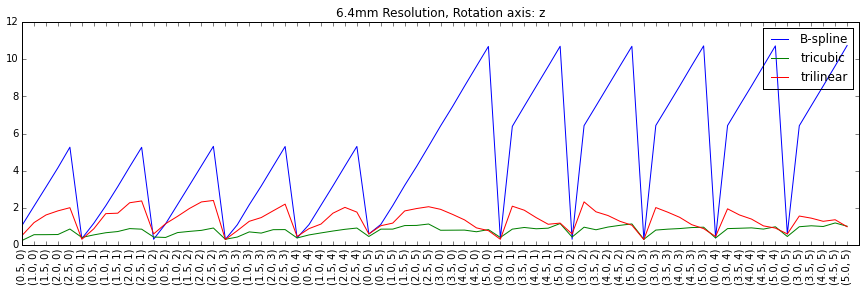

In [229]:
x = np.arange(0,70,1)
labels = true_params[:70]
for i in xrange(6):
    plt.figure(figsize=[15,4])
    plt.plot(RMS_ls_bspline_6_4[i*70:(i+1)*70], label = 'B-spline')
    plt.plot(RMS_ls_cubic_6_4[i*70:(i+1)*70], label = 'tricubic')
    plt.plot(RMS_ls_linear_6_4[i*70:(i+1)*70], label = 'trilinear')
    plt.title('6.4mm Resolution, Rotation axis: '+ axes_dict.keys()[i])
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()
    plt.show()